# Multivariate linear regression: Predicting the AQI (air quality index) using weather and pollution data for Aoti Zhongxin station - Beijing.

## Introduction
This data set includes air pollutants data from Aoti Zhongxin station(Beijing) taken from the Beijing Municipal Environmental Monitoring Center. Variables in this dataset include: time, measured concentrations of various pollutants, temperature, pressure, dew point, precipitation and wind information. The time period is: March 1st, 2013 - February 28th, 2017.  
AQI is a measurement for air quality that indicates how polluted the air currently is. It is calculated using the pollution levels of O3, PM2.5, PM10, CO, SO2 and NO2.  
We will use a multivariate linear regression model to answer the question "How do the chosen weather variables affect AQI in Beijing?".

## Methods & Results

In [1]:
# Load libraries, run before everything else
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("con2aqi")
library(con2aqi)
library(zoo) # for moving averages
install.packages("GGally")
library(GGally)
options(jupyter.plot_mimetypes = "image/png")  # Added by TA; we ran into 100mb file size limit problems

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# Get weather + pollution data for the Aotizhongxin station in Beijing
download.file("https://raw.githubusercontent.com/DonkeyBlaster/dsci-100-2023w1-group43/main/PRSA_Data_Aotizhongxin_20130301-20170228.csv", "Aotizhongxin_data.csv")
air_quality_data <- read_csv("Aotizhongxin_data.csv") |>
    select(-station) |> # This just says "Aotizhongxin", no need to keep it around
    select(-No) # This is a continuously increasing counter, we don't need it either
head(air_quality_data, 3)
tail(air_quality_data, 3)

Rows: 35064 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): wd, station
dbl (16): No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2013,3,1,0,4,4,4,7,300,77,-0.7,1023.0,-18.8,0,NNW,4.4
2013,3,1,1,8,8,4,7,300,77,-1.1,1023.2,-18.2,0,N,4.7
2013,3,1,2,7,7,5,10,300,73,-1.1,1023.5,-18.2,0,NNW,5.6


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2017,2,28,21,16,37,10,66,700,58,10.8,1014.2,-13.3,0,NW,1.1
2017,2,28,22,21,44,12,87,700,35,10.5,1014.4,-12.9,0,NNW,1.2
2017,2,28,23,19,31,10,79,600,42,8.6,1014.1,-15.9,0,NNE,1.3


AQI can be easily calculated with the "con2aqi" library (after wrangling). First, we remove any N/A values:

In [3]:
air_quality_data <- air_quality_data |> 
    na.omit() |> # AQI cannot be calculated with NA values\
    select(-wd) |>  # We don't know how to use this properly
    filter(year >= 2015, year <= 2016)  # We only want 2015-2016, measuring changed in 2014 and 2017 data is incomplete

# TODO: Explain why we are using 2015-2016 only, why we're removing wind direction, then remove the comments from my code

Additionally, we need to wrangle the pollutant units into ones the library understands. Existing data are in ug/m^3, and the library wants the following units:
| PM2.5  | PM10   | SO2 | NO2 | CO  | O3  |
|--------|--------|-----|-----|-----|-----|
| ug/m^3 | ug/m^3 | ppb | ppb | ppm | ppm |

In [4]:
R = 0.082057366080960  # Gas constant for litres, atmospheres, kelvin, mols.
SO2_molecular_weight = 64.07  # g/mol
NO2_molecular_weight = 46.01  # g/mol
CO_molecular_weight = 28.01  # g/mol
O3_molecular_weight = 48.00  # g/mol
air_quality_data <- air_quality_data |>
    # PV = nRT formula rearranged to V = RT/P, n=1.
    mutate(volume = R * (273.2 + TEMP) / (PRES/1013)) |>   # Convert temp to Kelvin, pressure to atmospheres
    mutate(so2_ppb = volume * SO2 / SO2_molecular_weight) |>
    mutate(no2_ppb = volume * NO2 / NO2_molecular_weight) |>
    # Multiply by div by 1000 for ppb -> ppm
    mutate(co_ppm = volume * CO / CO_molecular_weight / 1000) |>
    mutate(o3_ppm = volume * O3 / O3_molecular_weight / 1000)
head(air_quality_data, 3)
tail(air_quality_data, 3)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,1,0,13,50,19,29,500,28,-1,1027,-22.4,0,4.4,22.03153,6.533465,13.88643,0.3932798,0.01285173
2015,1,1,1,11,30,15,31,600,27,-1,1027,-23.7,0,5.6,22.03153,5.157999,14.84411,0.4719357,0.01239274
2015,1,1,2,13,33,16,32,600,26,-1,1028,-23.7,0,4.2,22.01010,5.496513,15.30805,0.4714766,0.01192214


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,12,31,21,409,444,9,163,5300,3,-3,1022.1,-5.3,0,0.9,21.97450,3.086788,77.84923,4.157974,0.001373406
2016,12,31,22,451,483,9,147,5000,3,-3,1022.7,-5.0,0,0.1,21.96161,3.084977,70.16640,3.920315,0.001372600
2016,12,31,23,472,504,9,140,5400,3,-4,1022.6,-5.7,0,0.9,21.88247,3.073860,66.58434,4.218683,0.001367654


Next, we need to calculate moving averages for the concentrations, as per [the specification](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf). Each pollutant has a different period required, shown below:
| PM2.5    | PM10     | SO2      | NO2    | CO      | O3           |
|----------|----------|----------|--------|---------|--------------|
| 24 hours | 24 hours | 1 hour   | 1 hour | 8 hours | 1 or 8 hours |


In [5]:
air_quality_data <- air_quality_data |>
    mutate(pm2.5_24hour = zoo::rollmean(PM2.5, k = 24, fill = NA, align = "right")) |>
    mutate(pm10_24hour = zoo::rollmean(PM10, k = 24, fill = NA, align = "right")) |>
    mutate(co_8hour = zoo::rollmean(co_ppm, k = 8, fill = NA, align = "right")) |>
    mutate(o3_8hour = zoo::rollmean(o3_ppm, k = 8, fill = NA, align = "right"))  # For o3 specifically, con2aqi allows us to choose 1 or 8 hours.
    # We're using 8 hours as the 1-hour window does not allow for reporting of AQI values less than 101.
head(air_quality_data, 26)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm,pm2.5_24hour,pm10_24hour,co_8hour,o3_8hour
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,1,0,13,50,19,29,500,28,⋯,4.4,22.03153,6.533465,13.886425,0.3932798,0.0128517269,NA,NA,NA,NA
2015,1,1,1,11,30,15,31,600,27,⋯,5.6,22.03153,5.157999,14.844110,0.4719357,0.0123927367,NA,NA,NA,NA
2015,1,1,2,13,33,16,32,600,26,⋯,4.2,22.01010,5.496513,15.308046,0.4714766,0.0119221377,NA,NA,NA,NA
2015,1,1,3,10,29,10,25,500,31,⋯,4.4,21.98871,3.431982,11.947789,0.3925154,0.0142010423,NA,NA,NA,NA
2015,1,1,4,12,25,14,33,700,24,⋯,1.4,21.95059,4.796446,15.743742,0.5485689,0.0109752966,NA,NA,NA,NA
2015,1,1,5,12,24,10,34,600,23,⋯,1.1,21.64455,3.378266,15.994669,0.4636462,0.0103713470,NA,NA,NA,NA
2015,1,1,6,6,18,4,19,500,34,⋯,1.6,21.58480,1.347576,8.913525,0.3853053,0.0152892357,NA,NA,NA,NA
2015,1,1,7,11,22,7,25,500,28,⋯,2.0,21.48314,2.347152,11.673084,0.3834906,0.0125318341,NA,NA,0.4387773,0.012566920
2015,1,1,8,12,20,11,49,600,10,⋯,0.9,21.60580,3.709440,23.009872,0.4628161,0.0045012084,NA,NA,0.4474694,0.011523105


Finally, we calculate AQI for each pollutant.

In [6]:
# This cell takes a while.
air_quality_data <- air_quality_data |>
    na.omit() |>  #  We will remove all rows with NA first.
    mutate(pm2.5_aqi = con2aqi(pollutant = "pm25", con = pm2.5_24hour)) |>
    mutate(pm10_aqi = con2aqi(pollutant = "pm10", con = pm10_24hour)) |>
    mutate(so2_aqi = con2aqi(pollutant = "so2", con = so2_ppb)) |>
    mutate(no2_aqi = con2aqi(pollutant = "no2", con = no2_ppb)) |>
    mutate(co_aqi = con2aqi(pollutant = "co", con = co_8hour)) |>
    mutate(o3_aqi = con2aqi(pollutant = "o3", con = o3_8hour, type = "8h"))
air_quality_data

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,pm2.5_24hour,pm10_24hour,co_8hour,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,2,0,109,134,49,100,2600,2,⋯,42.20833,65.75000,1.3088955,0.0050328119,118,57,24,45,15,5
2015,1,2,1,111,139,60,102,2700,2,⋯,46.29167,69.45833,1.4826739,0.0026420505,128,59,30,46,17,3
2015,1,2,2,101,123,51,93,2400,2,⋯,50.04167,73.33333,1.5956654,0.0010233792,137,61,25,42,19,1
2015,1,2,3,72,102,32,88,1700,2,⋯,52.50000,76.20833,1.6216046,0.0009067614,143,62,16,39,19,1
2015,1,2,4,48,82,26,77,1300,2,⋯,54.08333,78.41667,1.6130871,0.0009078973,147,63,13,35,19,1
2015,1,2,5,25,48,18,54,900,10,⋯,54.62500,79.37500,1.5343012,0.0013602461,149,64,9,25,18,2
2015,1,2,6,18,33,20,47,800,13,⋯,54.87500,79.75000,1.4282355,0.0019934767,149,64,10,22,17,2
2015,1,2,7,13,23,16,45,700,15,⋯,55.16667,79.95833,1.2724302,0.0027287598,150,64,8,21,15,3
2015,1,2,8,14,22,14,62,700,2,⋯,55.29167,79.95833,1.0887952,0.0027292748,150,64,7,28,13,3


Because AQI is reported daily as the highest of the individual pollutant AQIs, we can obtain one final AQI value per day.

In [22]:
air_quality_data <- air_quality_data |>
    rowwise() |>  # This is required for the max function to read row-by-row
    mutate(aqi = max(pm2.5_aqi:o3_aqi)) |>
    mutate(pollutant = which.max(pm2.5_aqi:o3_aqi)) |>  # gives us some number 1-6 representing a pollutant
    mutate(pollutant = as_factor(pollutant)) |>
    mutate(pollutant = recode_factor(pollutant, "1" = "pm2.5", "2" = "pm10", "3" = "so2", "4" = "no2", "5" = "co", "6" = "o3"))
head(air_quality_data, 3)
tail(air_quality_data, 3)
# Do not modify air_quality_data from this point onwards! It contains all original and calculated information. Duplicate frame if other modifications are needed.

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,co_8hour,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi,aqi,pollutant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
2015,1,2,0,109,134,49,100,2600,2,⋯,1.308896,0.005032812,118,57,24,45,15,5,118,pm2.5
2015,1,2,1,111,139,60,102,2700,2,⋯,1.482674,0.002642050,128,59,30,46,17,3,128,pm2.5
2015,1,2,2,101,123,51,93,2400,2,⋯,1.595665,0.001023379,137,61,25,42,19,1,137,pm2.5


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,co_8hour,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi,aqi,pollutant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
2016,12,31,21,409,444,9,163,5300,3,⋯,4.110981,0.002446250,339,177,5,77,47,3,339,pm2.5
2016,12,31,22,451,483,9,147,5000,3,⋯,4.249085,0.001796348,345,180,5,69,49,2,345,pm2.5
2016,12,31,23,472,504,9,140,5400,3,⋯,4.172648,0.001556257,352,183,5,65,48,2,352,pm2.5


In [23]:
# Retrieve training and testing splits
aqd_split <- initial_split(air_quality_data, prop = 0.75, strata = aqi)
aqd_train <- training(aqd_split)
aqd_test <- testing(aqd_split)
head(aqd_train, 4)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,co_8hour,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi,aqi,pollutant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
2015,1,6,10,14,18,29,26,700,29,⋯,0.5121352,0.01168598,73,57,15,12,6,11,73,pm2.5
2015,1,6,11,16,18,19,18,800,40,⋯,0.5432275,0.01196067,60,53,10,9,7,12,60,pm2.5
2015,1,6,12,12,12,14,12,700,48,⋯,0.5546308,0.01276975,53,48,8,6,7,12,53,pm2.5
2015,1,6,13,10,10,12,10,700,49,⋯,0.5658938,0.01368981,49,43,7,5,7,13,49,pm2.5


In [24]:
colnames(aqd_train)

[1] "year"         "month"        "day"          "hour"         "PM2.5"       
 [6] "PM10"         "SO2"          "NO2"          "CO"           "O3"          
[11] "TEMP"         "PRES"         "DEWP"         "RAIN"         "WSPM"        
[16] "volume"       "so2_ppb"      "no2_ppb"      "co_ppm"       "o3_ppm"      
[21] "pm2.5_24hour" "pm10_24hour"  "co_8hour"     "o3_8hour"     "pm2.5_aqi"   
[26] "pm10_aqi"     "so2_aqi"      "no2_aqi"      "co_aqi"       "o3_aqi"      
[31] "aqi"          "pollutant"

# TODO: We're going to do the pair plot analysis here to determine which variables are useful. Someone please fill details

,TEMP,PRES,DEWP,RAIN,WSPM,aqi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.0004915,0.7042818,-1.694916,-0.08025167,0.1850801,-1.041176
2,-0.9146612,0.7042818,-1.797609,-0.08025167,-0.6431411,-1.228616
3,-0.9146612,0.5101141,-1.856291,-0.08025167,0.3507243,-1.329545
4,-0.9146612,0.6071980,-1.856291,-0.08025167,1.3445898,-1.387219
5,-0.8288309,0.8984495,-1.797609,-0.08025167,1.3445898,-1.416056
6,-0.9146612,0.4130303,-1.922308,-0.08025167,1.5102340,-1.387219


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


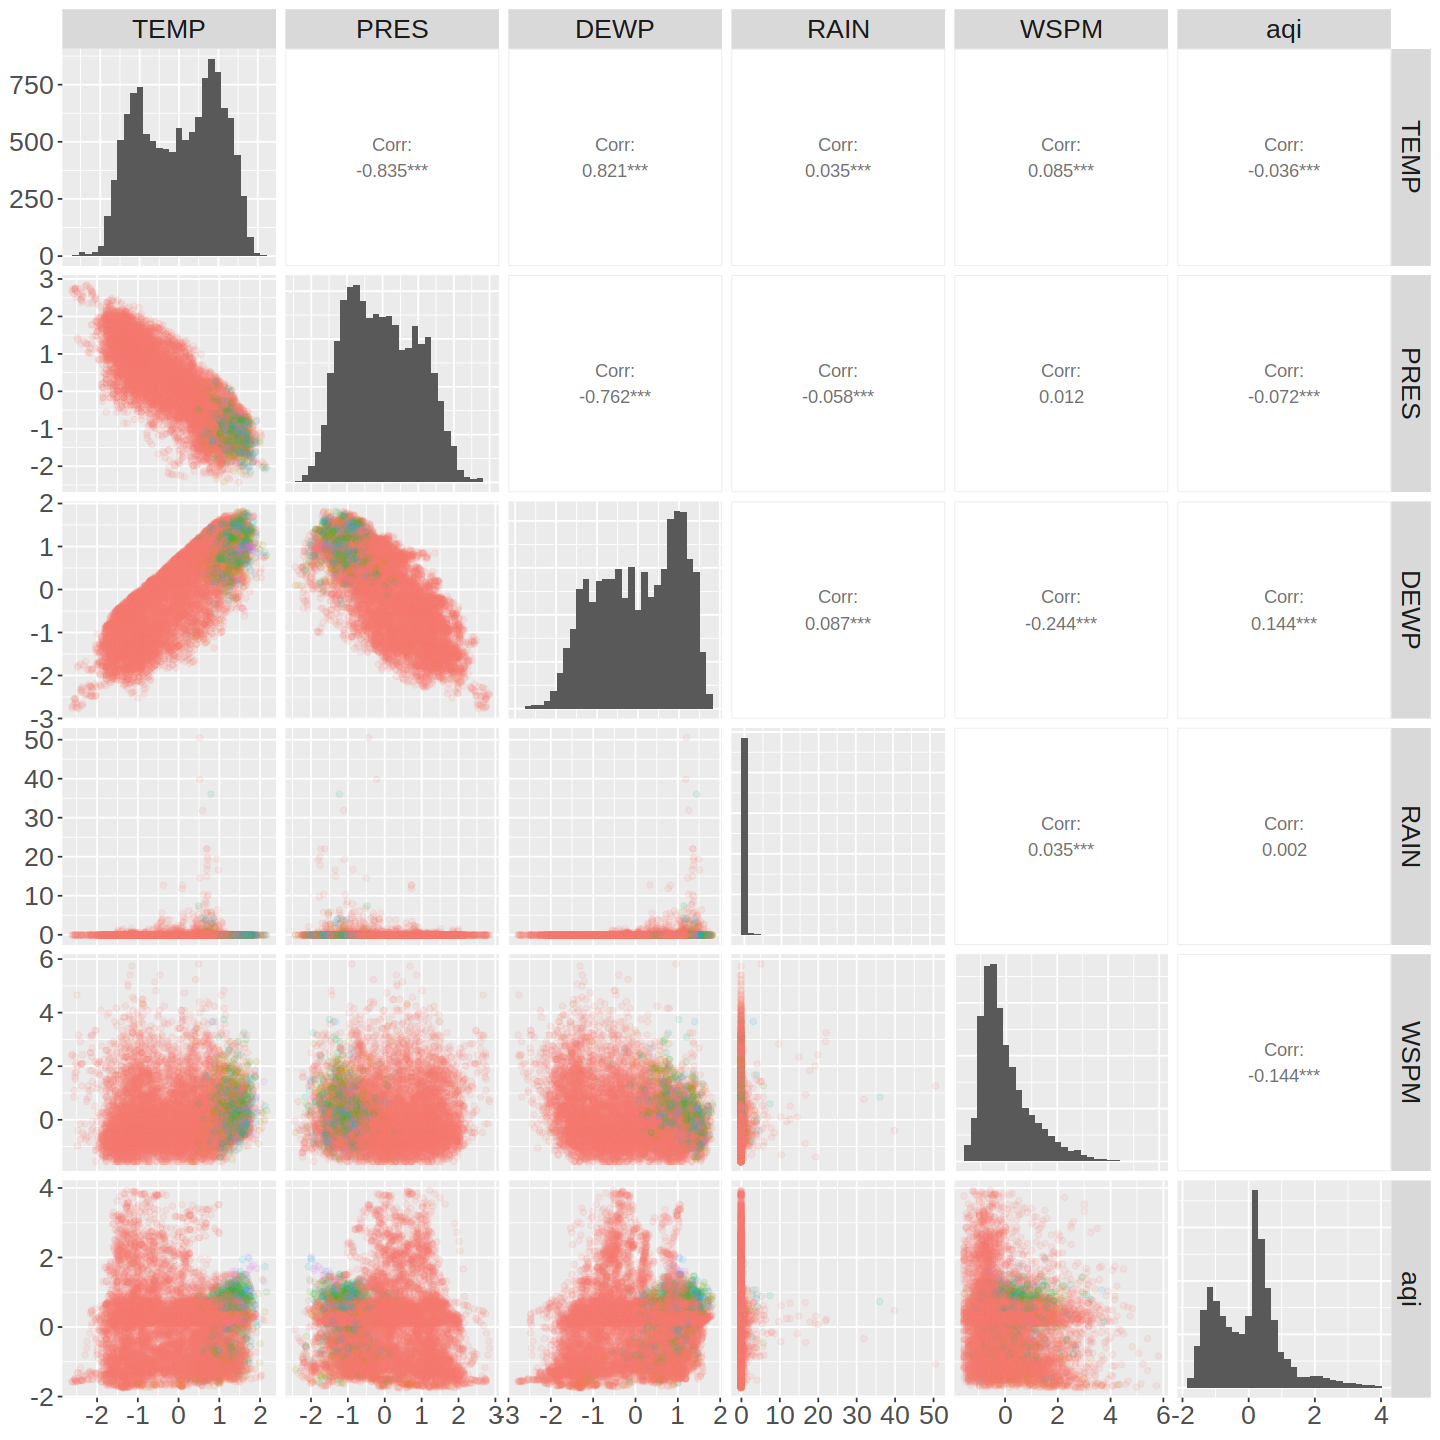

In [39]:
options(repr.plot.width = 12, repr.plot.height = 12)
aqd_pairplot <- aqd_train |>
    select(TEMP:WSPM, aqi) |>
    na.omit() |>
    scale() |>
    as.data.frame()

head(aqd_pairplot)

ggpairs(aqd_pairplot,
        lower = list(continuous = wrap('points', alpha = 0.1), mapping = aes(color = aqd_train$pollutant)),
        diag = list(continuous = "barDiag"), 
        cardinality_threshold = 134) +
    theme(text = element_text(size = 20))

# TODO: it is clear that TEMP and DEWP are very closely related, blah blah blah, we only pick one of them, so we have PRES DEWP WSPM, rain looks pretty terrible, blah blah, and so on

# TODO: but also it looks like none of them are particularly correlated with aqi, blah blah, what if we did just one pollutant individually? let's try a couple (totally not rigged ones that we picked)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


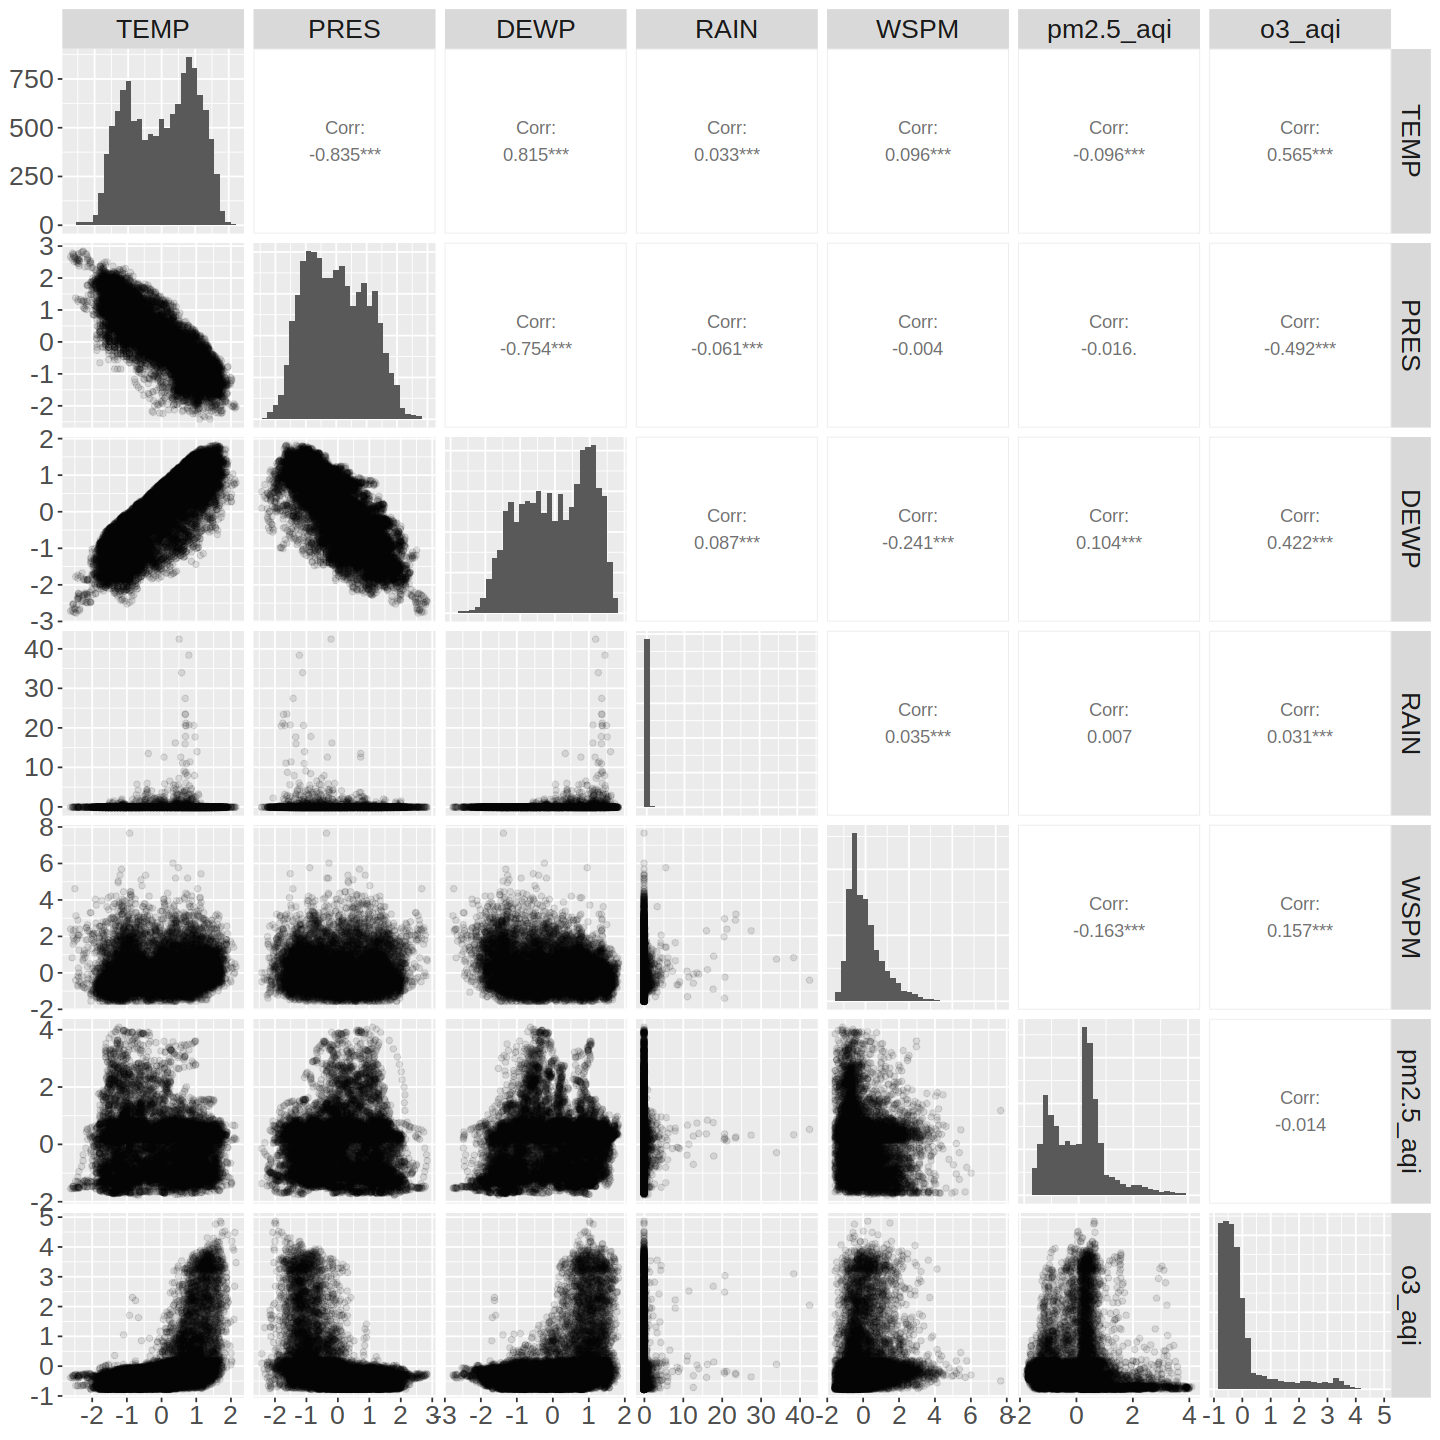

In [11]:
aqd_pairplot <- aqd_train |>
    select(TEMP:WSPM, pm2.5_aqi, o3_aqi) |>
    na.omit() |>
    scale() |>
    as.data.frame()
ggpairs(aqd_pairplot,
        lower = list(continuous = wrap('points', alpha = 0.1)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 20))

# TODO: clearly some pollutants are easier to predict (o3) and some are harder (pm2.5), what if we predicted individual pollutants to get an overall aqi value from that, etc (maybe move this to improvements?)

# TODO: let's do the linear regression with PRES and DEWP, predicting overall aqi now. We still have aqd_train and aqd_test, add details here

In [12]:
lm_spec <- linear_reg () |>
    set_engine("lm") |>
    set_mode("regression")
aqi_recipe <- recipe(aqi ~ PRES + DEWP, data = aqd_train)
aqi_fit <- workflow() |>
    add_model(lm_spec) |>
    add_recipe(aqi_recipe) |>
    fit(data = aqd_train)

# TODO: now we evaluate accuracy of model (it's pretty bad)

In [13]:
aqi_rmspe <- aqi_fit |>
    predict(aqd_test) |>
    bind_cols(aqd_test) |>
    metrics(truth = aqi, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
aqi_rmspe

[1] 68.21505

# TODO: This model is pretty terrible, RMSPE (measuring accuracy against never-seen-before data) is 69.1. Each aqi classification bracket is only 50

# TODO: What if we did it on the one pollutant that looks decent? (o3)

In [14]:
o3_recipe <- recipe(o3_aqi ~ PRES + DEWP, data = aqd_train)
o3_fit <- workflow() |>
    add_model(lm_spec) |>
    add_recipe(o3_recipe) |>
    fit(data = aqd_train)
o3_rmspe <- o3_fit |>
    predict(aqd_test) |>
    bind_cols(aqd_test) |>
    metrics(truth = o3_aqi, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
o3_rmspe

[1] 43.12094

# TODO: This is pretty good, within the 50-aqi bracket

## Method
We will carry out a multivariate linear regression analysis on our data, to predict AQI based on weather conditions. We chose this method because:
* Knn would be very slow for such a large dataset
* We can have more confidence in our model for predictions where weather conditions are slightly beyond the range of inputs (more extreme weather)
* The regression equation shows a mathematical relationship – quantifies the relative contribution of each predictor    

Before creating our model, we will consider each variable, and their relationships, as follows:
* Wind direction is given in the dataset, but disregarded as it is not numerical 
* The dataset is large - any outliers are not likely to strongly affect our results
* We will assess the relationships between our weather variables (by producing pairwise scatter plots), to identify correlations between them and avoid multicollinearity.



## Expected Outcomes and Significance

- Compared to **AQI**, based on our research, we expect:
    - Positive correlations with:
        - **Pressure** - higher pressures will stagnate air, causing pollutants to accumulate
    - Negative correlations with:
        - **Wind speed** - faster winds disperse pollutants, lowering concentrations
        - **Temperature** - higher ground temperature causes hot air to rise, reducing atmospheric pressure
        - **Precipitation** - this traps pollutants as they descend
        - **Dew point** - higher dew points form more water droplets, which traps pollutants
- Impacts:
    - Bad air quality contributes to thousands of hospital visits and premature deaths a year, with the related consequences totaling to an economic value of $120bn dollars a year. Thus, these findings could allow individuals to take preventative measures against pollution to protect their health.
- Future research:
  - We could use location-based predictors such as wind direction and topography to ask the question “How is AQI affected by location?”.
  - Additionally, we could ask “How is AQI affected by transportation and energy?” to investigate whether lifestyle contributes to pollution.


Word count: 517

### References

“Air pollution – How to convert between mg/m3, µg/m3 and ppm, ppb.” Breeze Technologies, 20 Aug.
2021,https://www.breeze-technologies.de/blog/air-pollution-how-to-convert-between-mgm3-%C2%B5gm3-ppm-ppb/. 
Accessed 28 Oct. 2023.


Feng, Xinyuan and Shigong Wang, “Influence of different weather events on concentrations of 
particulate matter with different sizes in Lanzhou, China.”Journal of Environmental
Sciences, Vol. 24, no. 4, 2012, pp. 665-674. https://doi.org/10.1016/S1001-0742(11)60807-3.


“Health impacts from air pollution.” Government of Canada, 2 June 2023, https://www.canada.ca/en/environment-climate-change/campaigns/canadian-environment-week/clean-air-day/health-impacts-air-pollution.html.  Accessed 28 Oct. 2023.


“How the weather affects air quality.” Government of Canada, 26 Jan. 2023,
https://www.canada.ca/en/environment-climate-change/services/air-quality-health-index/weather.html. 
Accessed 28 Oct. 2023.


Kumari, Shweta, and Manish Kumar Jane. (2018). “A Critical Review on Air Quality Index.” Water 
Science and Technology Library, vol. 77. Springer, Singapore. https://doi.org/10.1007/978-981-10-5792-2_8.


Liu, Yansui, Yang Zhou, and Jiaxin Lu. “Exploring the relationship between air pollution and
meteorological conditions in China under environmental governance.” Scientific Reports, vol.
10, no. 1, 2020, pp. 1-14. https://www.nature.com/articles/s41598-020-71338-7.
doi: 10.1038/s41598-020-71338-7.


Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index
(AQI). USEPA, 2018. https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf.


Xu, Yingying and Xinyue Zhu, "Recognizing Dew as an Indicator and an Improver of Near-Surface Air
Quality", Advances in Meteorology, vol. 2017, 2017. https://doi.org/10.1155/2017/3514743.

